In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### 문서 작성 (Paper Writing) Team 도구

In [3]:
import operator
from typing import Dict, Optional, List, TypedDict
from typing_extensions import Annotated

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent

from pathlib import Path
from langchain_core.tools import tool

In [4]:
WORKING_DIRECTORY = Path("./tmp")                   # 임시 디렉토리 생성 및 작업 디렉토리 설정

In [5]:
WORKING_DIRECTORY.mkdir(exist_ok=True)              # tmp 폴더가 없으면 생성

In [6]:
class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str      # 현재 작업중인 파일

In [ ]:
@tool                                               # 아웃라인(개요) 생성 및 파일로 저장하는 도구
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],) -> Annotated[str, "Path of the saved outline file."]:
    
    """Create and save an outline."""

    # 주어진 파일 이름으로 아웃라인을 저장
    with (WORKING_DIRECTORY / file_name).open("w", encoding='utf-8') as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    
    return f"Outline saved to {file_name}"

In [9]:
sample_points = [
    "서론",
    "본론",
]

create_outline.invoke({'points': sample_points, 'file_name': '아웃라인_예제.txt'})

'Outline saved to 아웃라인_예제.txt'

In [ ]:
@tool
def read_document(              # 문서 읽기 도구           
    file_name: Annotated[str, "File path to read the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None ) -> str:

    """Read the specified document."""
    
    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r", encoding='utf-8') as file:
        lines = file.readlines()
    
    # 시작 줄이 지정되지 않은 경우 기본값 설정
    if start is not None:
        start = 0
    
    return "\n".join(lines[start:end])


In [12]:
read_document.invoke({'file_name': '아웃라인_예제.txt'})

'1. 서론\n\n2. 본론\n'

In [13]:

@tool
def write_document(             # 문서 쓰기 및 저장 도구
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."]) -> Annotated[str, "Path of the saved document file."]:
    
    """Create and save a text document."""
    
    # 주어진 파일 이름으로 문서 저장
    with (WORKING_DIRECTORY / file_name).open("w", encoding='utf-8') as file:
        file.write(content)

    return f"Document saved to {file_name}"

In [14]:

@tool
def edit_document(          # 문서 편집 도구(특정 라인에 텍스트를 넣는)
    file_name: Annotated[str, "File path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line."
    ],
    ) -> Annotated[str, "File path of the edited document."]:
    
    """Edit a document by inserting text at specific line numbers."""

    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    # 삽입할 텍스트를 정렬하여 처리
    sorted_inserts = sorted(inserts.items())

    # 지정된 줄 번호에 텍스트 삽입
    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    # 편집된 문서를 파일에 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [15]:
from langgraph.graph import START, END
from langchain_core.messages import HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# 에이전트 팩토리 클래스
class AgentFactory:
    def __init__(self, model_name):
        self.llm = ChatOpenAI(model=model_name, temperature=0)

    def create_agent_node(self, agent, name: str):
        
        def agent_node(state):               # 노드 생성 함수   
            result = agent.invoke(state)
            return {
                "messages": [
                    HumanMessage(content=result["messages"][-1].content, name=name)
                ]
            }

        return agent_node


# LLM 초기화
llm = ChatOpenAI(model='gpt-4o', temperature=0)

# Agent Factory 인스턴스 생성
agent_factory = AgentFactory('gpt-4o')

In [16]:
class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str      # 현재 작업중인 파일

In [17]:
def preprocess(state):              # 상태 전처리 노드: 각각의 에이전트가 현재 작업 디렉토리의 상태를 더 잘 인식할 수 있도록 함

    written_files = []              # 작성된 파일 목록 초기화

    try:                                    
        written_files = [f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")]     # 작업 디렉토리 내의 모든 파일을 검색하여 상대 경로로 변환
    except Exception:
        pass
    
    if not written_files:           # 작성된 파일이 없으면 상태에 "No files written." 추가
        return {**state, "current_files": "No files written."}

    
    return {            # 작성된 파일 목록을 상태에 추가                        
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"+ "\n".join([f" - {f}" for f in written_files]),
    }

In [20]:
state1 = {"messages": ["파일 목록을 확인해줘"]}
new_state = preprocess(state1)
print(new_state)
print(new_state['current_files'])

{'messages': ['파일 목록을 확인해줘'], 'current_files': '\nBelow are files your team has written to the directory:\n - Transformer_논문_목차.txt\n - Transformer_논문_목차와_내용_분석.txt\n - 아웃라인_예제.txt'}

Below are files your team has written to the directory:
 - Transformer_논문_목차.txt
 - Transformer_논문_목차와_내용_분석.txt
 - 아웃라인_예제.txt


In [21]:
llm = ChatOpenAI(model='gpt-4o', temperature=0)

# 문서 작성 에이전트 생성
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    state_modifier="You are a arxiv researcher. Your mission is to write arxiv style paper on given topic/resources.",
)

context_aware_doc_writer_agent = preprocess | doc_writer_agent

doc_writing_node = agent_factory.create_agent_node(
    context_aware_doc_writer_agent, name="DocWriter"
)

In [22]:
# 노트 작성 노드
note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    state_modifier="You are an expert in creating outlines for research papers. Your mission is to create an outline for a given topic/resources or documents.",
)

context_aware_note_taking_agent = preprocess | note_taking_agent

note_taking_node = agent_factory.create_agent_node(
    context_aware_note_taking_agent, name="NoteTaker"
)

In [23]:
from langchain_experimental.tools import PythonREPLTool


python_repl_tool = PythonREPLTool()                 # PythonREPL 도구

chart_generating_agent = create_react_agent(        # 차트 생성 에이전트 생성
    llm, tools=[read_document, python_repl_tool]
)

context_aware_chart_generating_agent = preprocess | chart_generating_agent

chart_generating_node = agent_factory.create_agent_node(
    context_aware_chart_generating_agent, name="ChartGenerator"
)

In [24]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal


# 웹 연구 (Web Research) Team Supervisor
def create_team_supervisor(model_name, system_prompt, members) -> str:
    # 다음 작업자 선택 옵션 목록 정의
    options_for_next = ["FINISH"] + members

    # 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
    class RouteResponse(BaseModel):
        next: Literal[*options_for_next]


    # # ChatPromptTemplate 생성
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next? "
                "Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options_for_next))


    # # LLM 초기화
    llm = ChatOpenAI(model=model_name, temperature=0)

    # # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)

    return supervisor_chain

In [25]:
# 문서 작성 팀 감독자 생성
doc_writing_supervisor = create_team_supervisor(
    'gpt-4o',
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  ['DocWriter', 'NoteTaker', 'ChartGenerator']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

In [26]:
def get_next_node(x):
    return x["next"]

In [27]:
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
authoring_graph = StateGraph(DocWritingState)

# 노드 정의
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("Supervisor", doc_writing_supervisor)

# 엣지 정의
authoring_graph.add_edge("DocWriter", "Supervisor")
authoring_graph.add_edge("NoteTaker", "Supervisor")
authoring_graph.add_edge("ChartGenerator", "Supervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
authoring_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

# 시작 노드 설정
authoring_graph.set_entry_point("Supervisor")

# 그래프 컴파일
authoring_app = authoring_graph.compile(checkpointer=MemorySaver())

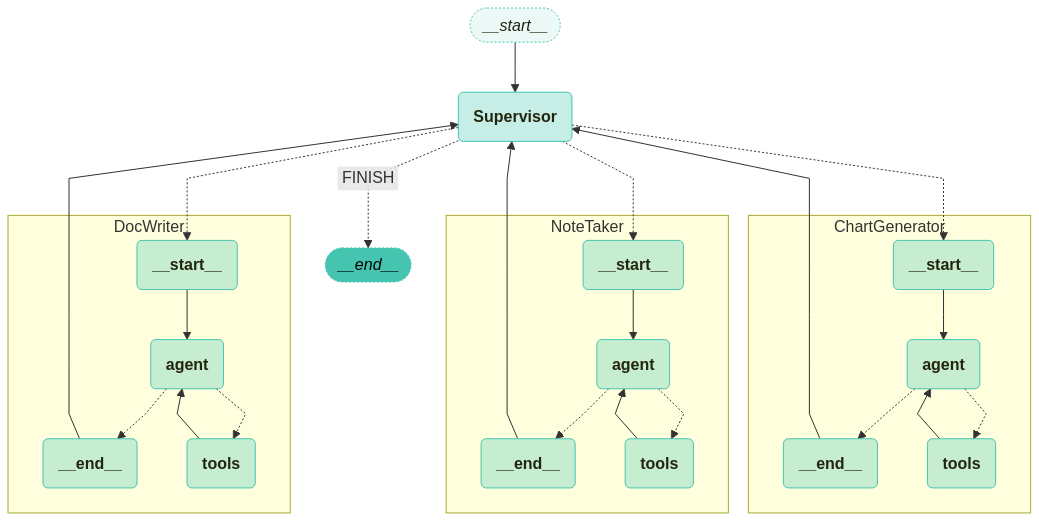

In [28]:
from langchain_teddynote.graphs import visualize_graph


visualize_graph(authoring_app, xray=True)       # 그래프 시각화

In [29]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig


def run_graph(app, message: str, recursive_limit: int = 50):
    config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    # 그래프 실행
    invoke_graph(app, inputs, config)

    return app.get_state(config).values

In [30]:
output = run_graph(
    authoring_app,
    "Transformer 의 구조에 대해서 심층 파악해서 논문의 목차를 한글로 작성해줘. "
    "그 다음 각각의 목차에 대해서 5문장 이상 작성해줘. "
    "상세내용 작성시 만약 chart 가 필요하면 차트를 작성해줘. "
    "최종 결과를 저장해줘. ",
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
DocWriter

🔄 Node: agent in [DocWriter] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  write_document (call_3B5lSO5i1XWNTK1vKq0pEi4y)
 Call ID: call_3B5lSO5i1XWNTK1vKq0pEi4y
  Args:
    content: # Transformer 논문 목차

1. 서론
2. Transformer의 기본 구조
3. Self-Attention 메커니즘
4. Positional Encoding
5. Multi-Head Attention
6. Feed-Forward Neural Networks
7. Residual Connections과 Layer Normalization
8. Transformer의 장점과 한계
9. 결론

---

## 1. 서론
Transformer는 자연어 처리 분야에서 혁신적인 변화를 가져온 모델로, 특히 기계 번역에서 뛰어난 성능을 보입니다. 이 논문에서는 Transformer의 구조와 작동 원리를 심층적으로 분석합니다. 기존의 RNN 기반 모델과의 차별점과 Transformer의 발전 배경을 살펴봅니다. 또한, Transformer가 다양한 자연어 처리 작업에서 어떻게 활용되는지에 대해 논의합니다. 마지막으로, Transformer의 미래 가능성과 연구 방향에 대해 간략히 언급합니다.

## 2. Transformer의 기본 구조
Transformer는 인코더와 디코더로 구성된 모델로, 각 부분은 여러 개의 층으로 이루어져 있습니다. 인코더는 입력 문장을 처리하여 의미 있는 표현을 생성하고, 디코더